In [128]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import re
import os

from config import config
import data_helpers
from data_generator import *

import matplotlib.pyplot as plt

In [129]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [130]:
df = data_helpers.read_large_excel(config['data'], "contest_total_data")
df = data_helpers.improve_contest_data(df)

In [131]:
tokenizer_team = creat_team_tokenizer(df)

encoding = tokenizer_team.encode("1 2 3 what? 333 -5 4)e_t grw0 1234 [HOME] [AWAY]")
# encoding = tokenizer.encode("")
print(encoding.tokens)
print(encoding.type_ids)
print(encoding.ids)

tokenizer_team.decode(encoding.ids)

['1', '2', '3', '[UNK]', '333', '[UNK]', '[UNK]', '[UNK]', '1234', '[HOME]', '[AWAY]']
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[3, 2046, 2921, 0, 3105, 0, 0, 0, 804, 1, 2]


'1 2 3 333 1234'

In [132]:
tokenizer_country = create_country_tokenizer(df)

countries = ['Argentina', 'Italy', 'WHAT', 'France', 'USA', 'Canada', '[UNK]', 'Unknown', '[AWAY_COUNTRY]', 'Chinese Taipei']
countries = [re.sub(r"\s", "_", item) for item in countries]
countries = " ".join(countries)
encoding = tokenizer_country.encode(countries)
# encoding = tokenizer.encode("")
print(encoding.tokens)
print(encoding.type_ids)
print(encoding.ids)

tokenizer_country.decode(encoding.ids)

['argentina', 'italy', '[UNK]', 'france', 'usa', 'canada', '[UNK]', '[UNK]', '[AWAY_COUNTRY]', 'chinese_taipei']
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[11, 111, 0, 84, 224, 42, 0, 0, 3, 51]


'argentina italy france usa canada chinese_taipei'

Text(0.5, 1.0, 'Max length of ids: 15')

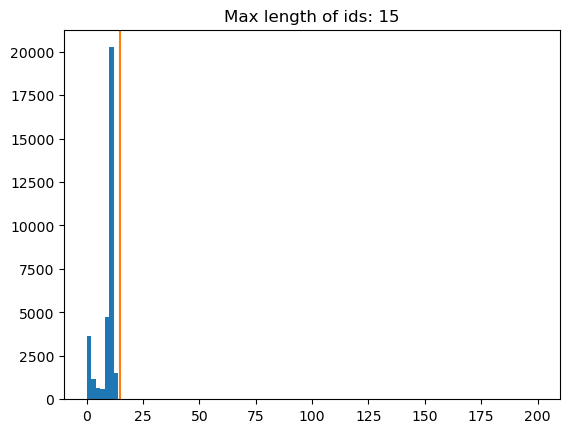

In [133]:
# id_to_ids_filename = 'ids-5.0-0.1-12.0-0.9-0.8-120-0.00001-7.0-32601-134'
# id_to_ids_filename = 'ids-5.0-0.01-15.0-0.9-0.8-130-0.000005-22.28-32601-140'
id_to_ids_filename = 'ids-5.0-0.01-15.0-0.9-0.8-10-0.000005-26.64-32601-15'
# id_to_ids_filename = 'ids-5.0-0.1-5.0-0.9-0.8-30-0.0001-9.98-32601-41'

(bookie_profit_percent, a_conductance_search, b_conductance_search, conductance365, 
        conductanceMedTeam, ids_max, minConductanceStep, hours, nDataPoints, maxLen) \
= data_helpers.filename_to_dataParams(id_to_ids_filename)
path = os.path.join('./data', 'id_to_ids', id_to_ids_filename + '.json')
fixture_id_to_ids = data_helpers.LoadJsonData(path)

lengths = [len(ids) for ids in fixture_id_to_ids.values()]
plt.hist(lengths, np.linspace(0, 200, 101))
plt.ylim(plt.ylim())
maxLen = max(lengths)
plt.plot([maxLen, maxLen], plt.ylim())
plt.title(f'Max length of ids: {maxLen}')

In [134]:
def generate_dataset(df, fixture_id_to_ids, tokenizer_team, tokenizer_country):

    BBAB_cols = [
        'teams_home_team_id', 'teams_away_team_id',                     # 0, 1
        'fixture_date',                                                 # 2,
        'league_country', 'home_team_country', 'away_team_country',     # 3, 4, 5
        'winning_percent_home', 'winning_percent_draws', 'winning_percent_away',  # 6, 7, 8
        'outcome'                                                       # 9
    ]
    len_normal_bbab = len(BBAB_cols)

    dummy_wining_percent = (80, 10, 10)         
    dummy_odds = [
        data_helpers.get_odds(dummy_wining_percent[0]/100, config['bookie_profit_percent']),
        data_helpers.get_odds(dummy_wining_percent[1]/100, config['bookie_profit_percent']),
        data_helpers.get_odds(dummy_wining_percent[2]/100, config['bookie_profit_percent']),
    ]
    dummy_bbab = \
        tokenizer_team.encode('[HOME] [AWAY]').ids \
        + [0] \
        + tokenizer_country.encode('[LEAGUE_COUNTRY] [HOME_COUNTRY] [AWAY_COUNTRY]').ids \
        + dummy_odds \
        + [1]
    dummy_bbab = tf.constant(dummy_bbab, dtype=tf.float32)
    
    def normalize_raw_bbab(bbab):
        pair_str = [str(team) for team in bbab[0:2]]
        pair_text = " ".join(pair_str)
        pair_tokens = tokenizer_team.encode(pair_text).ids
        bbab[0:2] = pair_tokens

        bbab[2] = (bbab[2].to_pydatetime() - config['baseDate']).days
        
        for idx in (6, 7, 8):
                bbab[idx] = data_helpers.get_odds(bbab[idx]/100, config['bookie_profit_percent'])
        countries_str = [re.sub(r"\s", "_", item) for item in bbab[3:6]]
        countries_text = " ".join(countries_str)
        countries_tokens = tokenizer_country.encode(countries_text).ids
        bbab[3:6] = countries_tokens
        # print(bbab)  
        return bbab


    def get_base_and_sequence(df, baseId, ids):
        try:
            base_bbab = list(df.loc[df['fixture_id'] == baseId, BBAB_cols].iloc[0])
            base_bbab = normalize_raw_bbab(base_bbab)
            base_bbab = np.array(base_bbab, dtype=np.float32)

            sequence = np.array([[]] * len_normal_bbab).T  # shape: (0, len_normal_bbab)
            for id in ids:
                bbab = list(df.loc[df['fixture_id'] == id, BBAB_cols].iloc[0])
                bbab = normalize_raw_bbab(bbab)
                sequence = np.append(sequence, [bbab], axis=0)

            return (baseId, base_bbab, sequence)
        except:
            raise Exception("Failed to get_BBAB for baseId = {}".format(baseId))    
        

    def generator():    
        for baseId, ids in fixture_id_to_ids.items():
            print(baseId, ids, end='\r')
            base_and_sequence = get_base_and_sequence(df, int(baseId), ids)
            # print(base_and_sequence)

            yield base_and_sequence

    ds = tf.data.Dataset.from_generator(
        generator,
        output_types=(tf.int32, tf.float32, tf.float32),
        output_shapes=(tf.TensorShape(()), tf.TensorShape((len_normal_bbab,)), tf.TensorShape((None, len_normal_bbab))),
        args=()
    )

    return ds

In [135]:
ds_path = os.path.join('./data', 'datasets', id_to_ids_filename)

ds = generate_dataset(df, fixture_id_to_ids, tokenizer_team, tokenizer_country)
for item in ds:
    # print(item[0].shape, item[1].shape, item[2].shape)
    pass
# tf.data.Dataset.save(ds, ds_path)

# ds = tf.data.Dataset.load(ds_path)

KeyboardInterrupt: 

In [ ]:
# for item in ds:
#     interprete_dataset_item(item, tokenizer_team, tokenizer_country, fixture_id_to_ids, df)

In [ ]:
dataset_size = len(ds)
train_size = int(0.85 * dataset_size)
test_size = dataset_size - train_size

train_ds = ds.take(train_size)
test_ds = ds.skip(train_size)

print(len(train_ds), len(test_ds), len(ds), len(ds)-len(train_ds)-len(test_ds))

In [ ]:
MAX_TOKENS=15
def prepare_batch(sequence, base):
    # (None,) (None, 12) (None, None, 12)
    # sequence = sequence.to_tensor()
    # pt = tokenizers.pt.tokenize(pt)      # Output is ragged.
    # pt = pt[:, :MAX_TOKENS]    # Trim to MAX_TOKENS.
    # pt = pt.to_tensor()  # Convert from ragged to 0-padded dense Tensor
    # en = tokenizers.en.tokenize(en)
    # en = en[:, :(MAX_TOKENS+1)]
    # en_inputs = en[:, :-1].to_tensor()  # Drop the [END] tokens
    # en_labels = en[:, 1:].to_tensor()   # Drop the [START] tokens
    # return (pt, en_inputs), en_labels
    print(sequence.shape, base.shape)
    return (sequence, base)

In [ ]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [ ]:
def normalize_row(baseId, base, sequence):
    # shape: () (12,) (None, 12)
    # print(tf.shape(baseId), tf.shape(base), tf.shape(sequence))
    # print(baseId.shape, base.shape, sequence.shape)
    elem = tf.constant([0,1,2,3,4,5,6,7,8,9,0,11], dtype=tf.float32)
    block = tf.stack([elem] * MAX_TOKENS-tf.shape(sequence)[0], axis=0)
    paddings = [[0, MAX_TOKENS-tf.shape(sequence)[0]], [0, 0]]
    constant = -1 #sequence[0]
    # sequence = tf.pad(sequence, paddings, 'CONSTANT', constant_values=constant)
    sequence = tf.cast(sequence, dtype=tf.float32)
    sequence = tf.concat([sequence, elem], axis=0)
    print(sequence.shape)
    return (sequence, base)

In [ ]:
def make_batches(ds):
    return (
        ds
        .map(normalize_row, tf.data.AUTOTUNE)   # returns sequence, base
        # .shuffle(BUFFER_SIZE)
        # .batch(BATCH_SIZE)
        # .map(prepare_batch, tf.data.AUTOTUNE)
        # .cache()
        # .prefetch(buffer_size=tf.data.AUTOTUNE)
        )

In [ ]:
train_batches = make_batches(train_ds)
test_batches = make_batches(test_ds)

In [ ]:
for elem in train_batches:
    pass

In [ ]:
def interprete_BB_AB(bbab, tokenizer_team, tokenizer_country):
    pair_string = tokenizer_team.decode(np.array(bbab[0:2], dtype=np.int32))
    days = bbab[2]
    date = config['baseDate'] + datetime.timedelta(days=int(days))
    country_string = tokenizer_country.decode(np.array(bbab[3:6], dtype=np.int32))
    odds = bbab[6:9]
    wp = tuple(data_helpers.get_probability(odds, config['bookie_profit_percent'])*100)
    winning_percent = (round(wp[0]), round(wp[1]), round(wp[2]))
    outcome = tuple(np.array(bbab[9:12], dtype=np.int32))
    # print("outcome", outcome)
    outcome = 0 if outcome == (1, 0, 0) else 1 if outcome == (0, 1, 0) else 2
    return pair_string, date, country_string, winning_percent, outcome

def interprete_dataset_item(item, tokenizer_team, tokenizer_country, id_to_ids, df):
    baseId = item[0].numpy()
    baseOutput = item[1].numpy()
    print(baseOutput)
    sequence = item[2].numpy()
    print(sequence)

    print("baseId: ", baseId)
    print("baseOutput: ", interprete_BB_AB(baseOutput, tokenizer_team, tokenizer_country))

    ids = id_to_ids[str(baseId)]
    for i in range(sequence.shape[0]):
        id = ids[i] if len(ids) > 0 else 0
        print("sequence {}, {}".format(i, id), interprete_BB_AB(sequence[i], tokenizer_team, tokenizer_country))
